In [1]:
import pandas as pd
import numpy as np
import shutup
shutup.please()
import sklearn
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import itertools
import sys
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_pickle('monthly_crime_df.pkl')
df

,crime_count
Date,
2020-01-01,596.161290
2020-02-01,594.896552
2020-03-01,521.193548
2020-04-01,522.533333
2020-05-01,554.838710
2020-06-01,567.600000
2020-07-01,552.064516
2020-08-01,544.161290
2020-09-01,521.033333


## Seasonal Decomposition

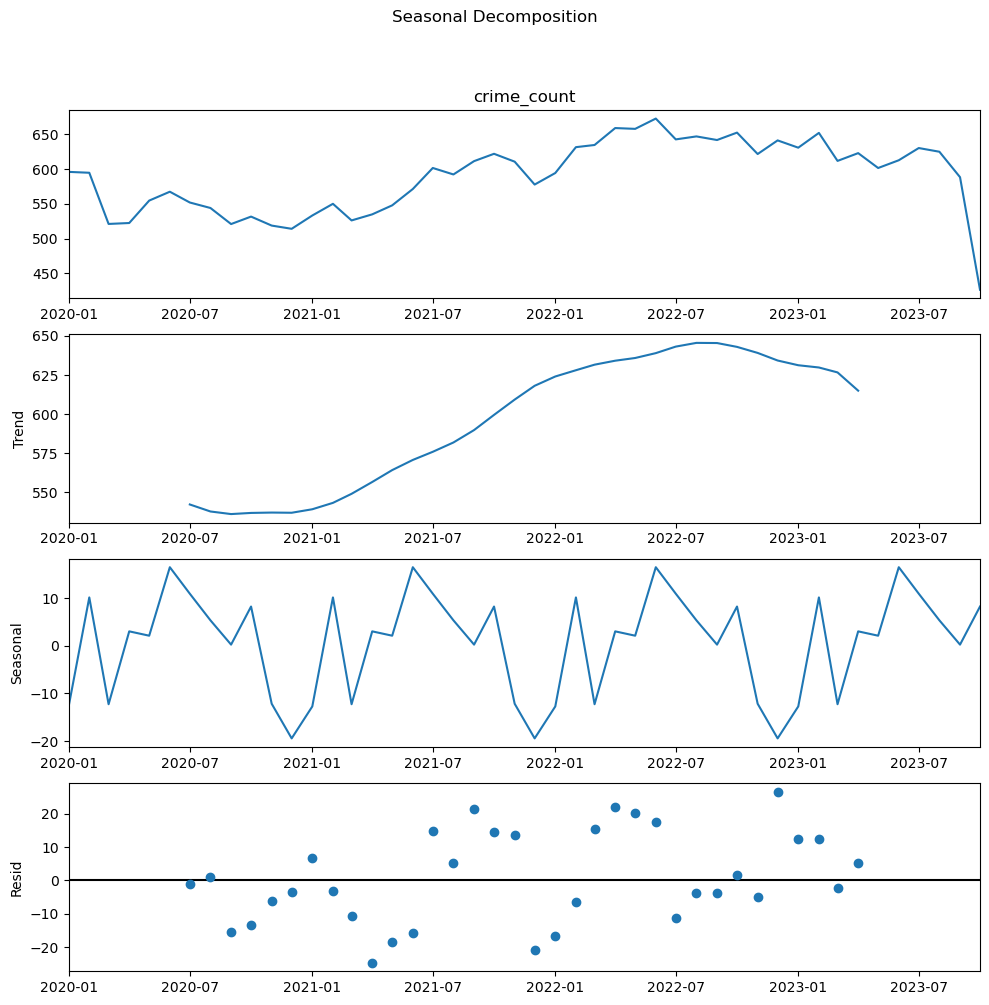

In [3]:
df.index = pd.to_datetime(df.index)
result = seasonal_decompose(df['crime_count'], 
                            model = 'additive', 
                            period = 12)
plt.rcParams.update({'figure.figsize': (10, 10)})
result.plot()
plt.tight_layout()
plt.suptitle('Seasonal Decomposition', y = 1)
plt.subplots_adjust(top = 0.9)
plt.savefig('./fig/Seasonal Decomposition.png')
plt.show()

## Differencing

In [4]:
periods = [1, 2, 3, 4]
differenced_dfs = {period: df['crime_count'].diff(period) for period in periods}

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag = 'AIC')
    labels = ['ADF Test Statistic', 'p-value', 
              '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index = labels)

    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val

    print(out.to_string())
    print("\n")

for period, diff_df in differenced_dfs.items():
    adf_test(diff_df, title = f'Period {period}')

Augmented Dickey-Fuller Test: Period 1
ADF Test Statistic      -3.704476
p-value                  0.004051
# Lags Used              0.000000
# Observations Used     44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185


Augmented Dickey-Fuller Test: Period 2
ADF Test Statistic      -3.815483
p-value                  0.002753
# Lags Used              1.000000
# Observations Used     42.000000
Critical Value (1%)     -3.596636
Critical Value (5%)     -2.933297
Critical Value (10%)    -2.604991


Augmented Dickey-Fuller Test: Period 3
ADF Test Statistic       0.139919
p-value                  0.968683
# Lags Used              8.000000
# Observations Used     34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447


Augmented Dickey-Fuller Test: Period 4
ADF Test Statistic      -0.705564
p-value                  0.845303
# Lags Used              3.000000
# Observations Used   

#### Will take period = 2 be the differenced time serise since it has lowest p-value on Dickey-Fuller Test

## AR(1) and MA(1) on origin dataset

In [5]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit AR(1) model
ar_model_train = ARIMA(train, order=(1, 0, 0)).fit()

# Fit MA(1) model
ma_model_train = ARIMA(train, order=(0, 0, 1)).fit()

# Predictions
ar_predictions = ar_model_train.predict(start = len(train), 
                                        end = len(train) + len(test) - 1, 
                                        dynamic = False)
ma_predictions = ma_model_train.predict(start = len(train), 
                                        end = len(train) + len(test) - 1, 
                                        dynamic = False)

In [6]:
ar_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   36
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -162.439
Date:                Mon, 04 Dec 2023   AIC                            330.878
Time:                        02:13:34   BIC                            335.629
Sample:                    01-01-2020   HQIC                           332.537
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        596.6091     38.497     15.498      0.000     521.157     672.061
ar.L1          0.8894      0.091      9.807      0.000       0.712       1.067
sigma2       465.4627     93.767      4.964      0.000     281.684     649.242
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                11.31
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -1.03
Prob(H) (two-sided):                  0.39   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
ma_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   36
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -177.119
Date:                Mon, 04 Dec 2023   AIC                            360.238
Time:                        02:13:34   BIC                            364.989
Sample:                    01-01-2020   HQIC                           361.896
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        587.5001      9.434     62.272      0.000     569.009     605.991
ma.L1          0.7304      0.179      4.077      0.000       0.379       1.082
sigma2      1075.9447    328.276      3.278      0.001     432.536    1719.354
===================================================================================
Ljung-Box (L1) (Q):                   9.64   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.00   Prob(JB):                         0.71
Heteroskedasticity (H):               1.39   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
ar_1_rmse = sqrt(mean_squared_error(test, ar_predictions))
ma_1_rmse = sqrt(mean_squared_error(test, ma_predictions))

ar_1_rmse, ma_1_rmse

(59.91115728161779, 60.10371622664124)

#### Since AR model on origin dataset has lower rmse, so the AR(1) better than MA(1) model.

## AR and MA model on order 2 differenced dataset

In [9]:
df_diff_2 = df['crime_count'].diff(periods = 2)
df_diff_2_clean = df_diff_2.dropna()

train_size_diff_2 = int(len(df_diff_2_clean) * 0.8)
train_diff_2, test_diff_2 = df_diff_2_clean.iloc[:train_size_diff_2], df_diff_2_clean.iloc[train_size_diff_2:]

# Fit AR(1) model 
ar_model_train_diff_2 = ARIMA(train_diff_2, order=(1, 0, 0)).fit()

# Fit MA(1) model
ma_model_train_diff_2 = ARIMA(train_diff_2, order=(0, 0, 1)).fit()

# Predictions
ar_predictions_diff_2 = ar_model_train_diff_2.predict(start = len(train_diff_2), 
                                                      end = len(train_diff_2) + len(test_diff_2) - 1, 
                                                      dynamic = False)
ma_predictions_diff_2 = ma_model_train_diff_2.predict(start = len(train_diff_2), 
                                                      end = len(train_diff_2) + len(test_diff_2) - 1, 
                                                      dynamic = False)

In [10]:
ar_model_train_diff_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   35
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -165.873
Date:                Mon, 04 Dec 2023   AIC                            337.746
Time:                        02:13:34   BIC                            342.412
Sample:                    03-01-2020   HQIC                           339.356
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5271      9.204      0.057      0.954     -17.513      18.567
ar.L1          0.4854      0.135      3.587      0.000       0.220       0.751
sigma2       759.7172    175.318      4.333      0.000     416.101    1103.334
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.30   Prob(JB):                         0.87
Heteroskedasticity (H):               0.41   Skew:                             0.15
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
ma_model_train_diff_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   35
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -158.432
Date:                Mon, 04 Dec 2023   AIC                            322.864
Time:                        02:13:34   BIC                            327.530
Sample:                    03-01-2020   HQIC                           324.475
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9456      6.665      0.292      0.770     -11.117      15.009
ma.L1          0.9989      6.386      0.156      0.876     -11.518      13.516
sigma2       452.2465   2878.101      0.157      0.875   -5188.728    6093.221
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.95   Prob(JB):                         0.91
Heteroskedasticity (H):               0.41   Skew:                            -0.16
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
ar_rmse_diff_2 = sqrt(mean_squared_error(test_diff_2, 
                                         ar_predictions_diff_2))
ma_rmse_diff_2 = sqrt(mean_squared_error(test_diff_2, 
                                         ma_predictions_diff_2))

ar_rmse_diff_2, ma_rmse_diff_2

(70.01991341463393, 70.63381704543875)

#### Since AR model on order 2 differenced dataset has lower rmse, so the AR better than MA model.

In [13]:
ar_1_rmse, ma_1_rmse, ar_rmse_diff_2, ma_rmse_diff_2

(59.91115728161779, 60.10371622664124, 70.01991341463393, 70.63381704543875)

#### Since AR model on origin dataset has lower rmse which is 59.91, so the AR model on origin dataset is better.

## ARMA model on origin dataset

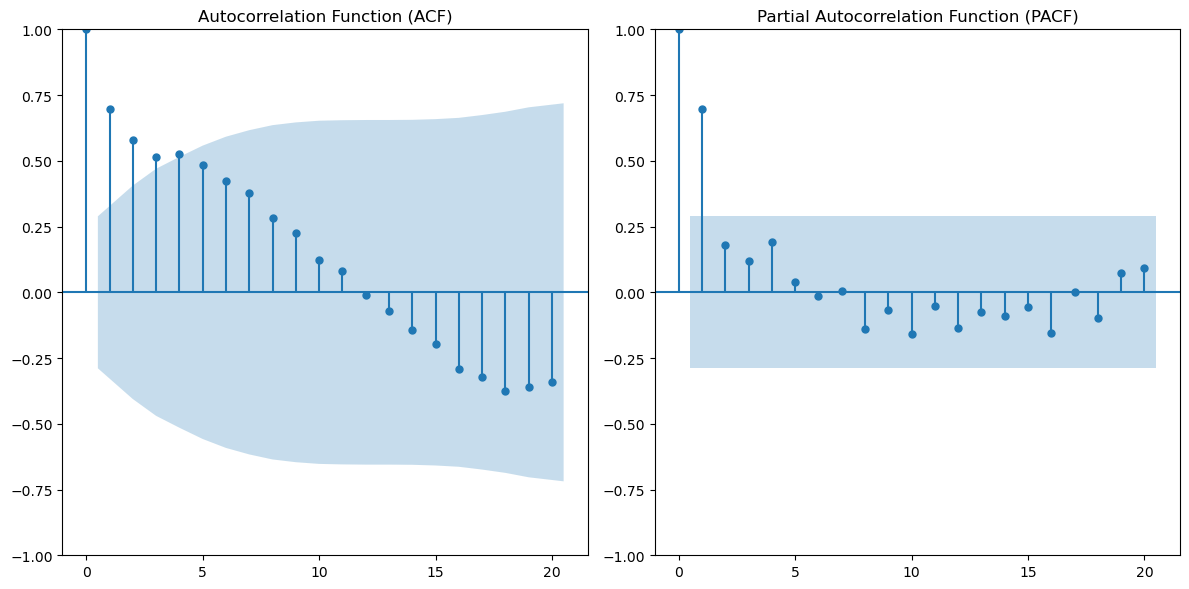

In [14]:
# Plotting ACF and PACF for the original dataset
plt.figure(figsize = (12, 6))

plt.subplot(121)
plot_acf(df['crime_count'], ax = plt.gca(), lags = 20, 
         title = 'Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(df['crime_count'], ax=plt.gca(), lags = 20, method = 'ywm', 
          title = 'Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.savefig('./fig/ACF & PACF Plot.png')
plt.show()

In [15]:
p = q = range(1, 11)
d = 2  # Fixed differencing order

pdq_combinations = list(itertools.product(p, [d], q))
aic_scores = {}

for combination in pdq_combinations:
    try:
        model = ARIMA(train, order = combination).fit()
        aic_scores[combination] = model.aic
    except Exception as e:
        aic_scores[combination] = None
        continue

# Display the AIC scores
for combo, aic in aic_scores.items():
    if aic is not None:
        print(f"ARIMA{combo}: AIC={aic}")

ARIMA(1, 2, 1): AIC=317.98832182125847
ARIMA(1, 2, 2): AIC=319.00896338597704
ARIMA(1, 2, 3): AIC=320.7710843737665
ARIMA(1, 2, 4): AIC=316.60211642439384
ARIMA(1, 2, 5): AIC=318.5974700957726
ARIMA(1, 2, 6): AIC=319.578986777061
ARIMA(1, 2, 7): AIC=321.4712020362479
ARIMA(1, 2, 8): AIC=326.0461834568683
ARIMA(2, 2, 1): AIC=319.0405861961746
ARIMA(2, 2, 2): AIC=320.8549189058796
ARIMA(2, 2, 3): AIC=319.7150772602176
ARIMA(2, 2, 4): AIC=318.5971697587157
ARIMA(2, 2, 5): AIC=320.52103158795916
ARIMA(2, 2, 6): AIC=319.59391741133027
ARIMA(2, 2, 7): AIC=321.976372597935
ARIMA(2, 2, 8): AIC=328.4144801496594
ARIMA(3, 2, 1): AIC=319.6838947769175
ARIMA(3, 2, 2): AIC=321.12509276883986
ARIMA(3, 2, 3): AIC=320.0230227780025
ARIMA(3, 2, 4): AIC=321.63899715244156
ARIMA(3, 2, 5): AIC=323.4811902495587
ARIMA(3, 2, 6): AIC=324.14687087655136
ARIMA(3, 2, 7): AIC=322.8301644835142
ARIMA(3, 2, 8): AIC=328.0104012255019
ARIMA(4, 2, 1): AIC=320.7051790328088
ARIMA(4, 2, 2): AIC=321.8074089073094
ARIMA(

#### ARIMA(1, 2, 4): AIC=316.60211642439384 has the lowest AIC score which is  a good model in those interaction

In [16]:
model5 = ARIMA(train, order = (1, 2, 4)).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   36
Model:                 ARIMA(1, 2, 4)   Log Likelihood                -152.301
Date:                Mon, 04 Dec 2023   AIC                            316.602
Time:                        02:14:02   BIC                            325.760
Sample:                    01-01-2020   HQIC                           319.725
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5750      0.244     -2.356      0.018      -1.053      -0.097
ma.L1         -0.4128      1.422     -0.290      0.772      -3.200       2.375
ma.L2         -0.9373      0.506     -1.852      0.064      -1.929       0.055
ma.L3         -0.1194      0.952     -0.125      0.900      -1.986       1.747
ma.L4          0.8266      1.157      0.715      0.475      -1.440       3.094
sigma2       370.8073    474.366      0.782      0.434    -558.933    1300.548
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.97   Prob(JB):                         0.55
Heteroskedasticity (H):               0.51   Skew:                            -0.22
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# predict on test data
model5_predictions = model5.predict(start = len(train), 
                                    end = len(train) + len(test) - 1, 
                                    dynamic = False)
model5_rmse = sqrt(mean_squared_error(test, model5_predictions))
model5_rmse

55.12448949852617

In [18]:
ar_1_rmse, ma_1_rmse, ar_rmse_diff_2, ma_rmse_diff_2, model5_rmse

(59.91115728161779,
 60.10371622664124,
 70.01991341463393,
 70.63381704543875,
 55.12448949852617)

#### So, the ARIMA model with ARIMA(1, 2, 4) have the lowest rmse, it a good model now!

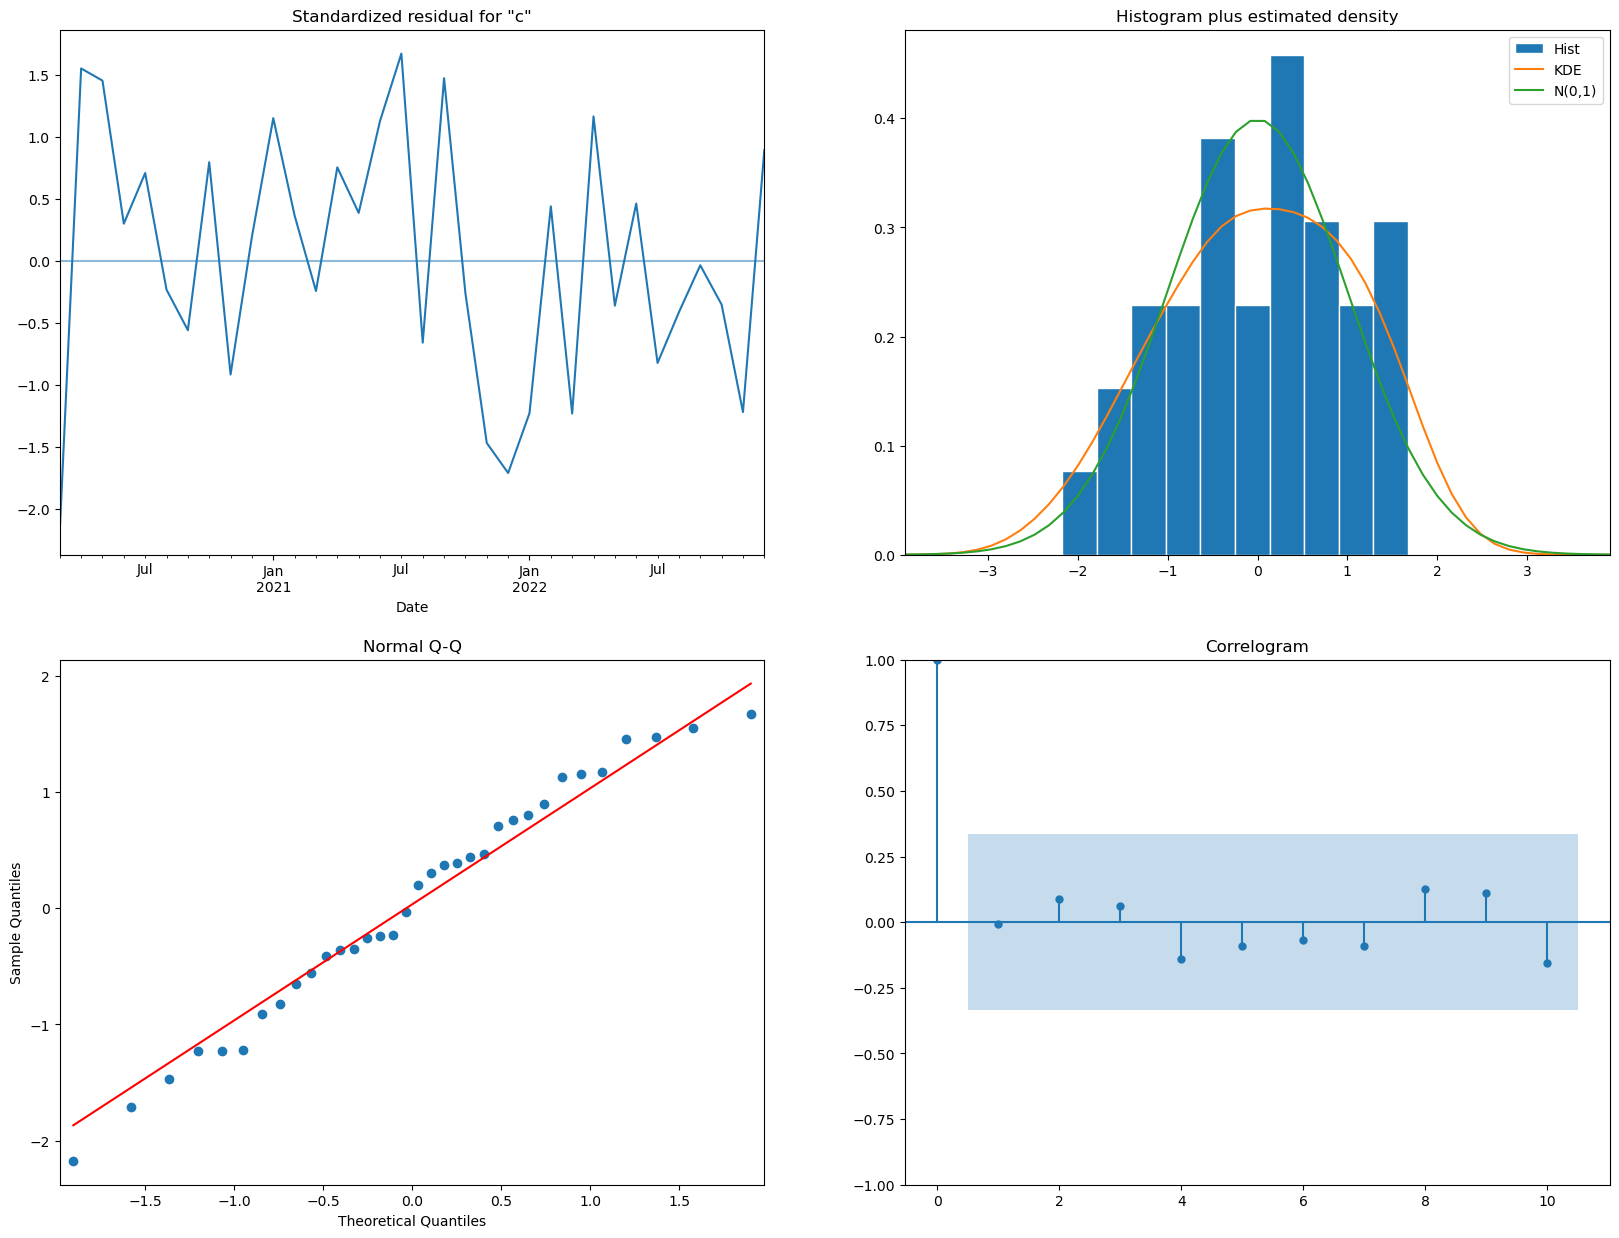

In [19]:
model5.plot_diagnostics(figsize = (20, 15))
plt.savefig('./fig/Diagnostics plots.png')
plt.show()

## time series forecasting prediction

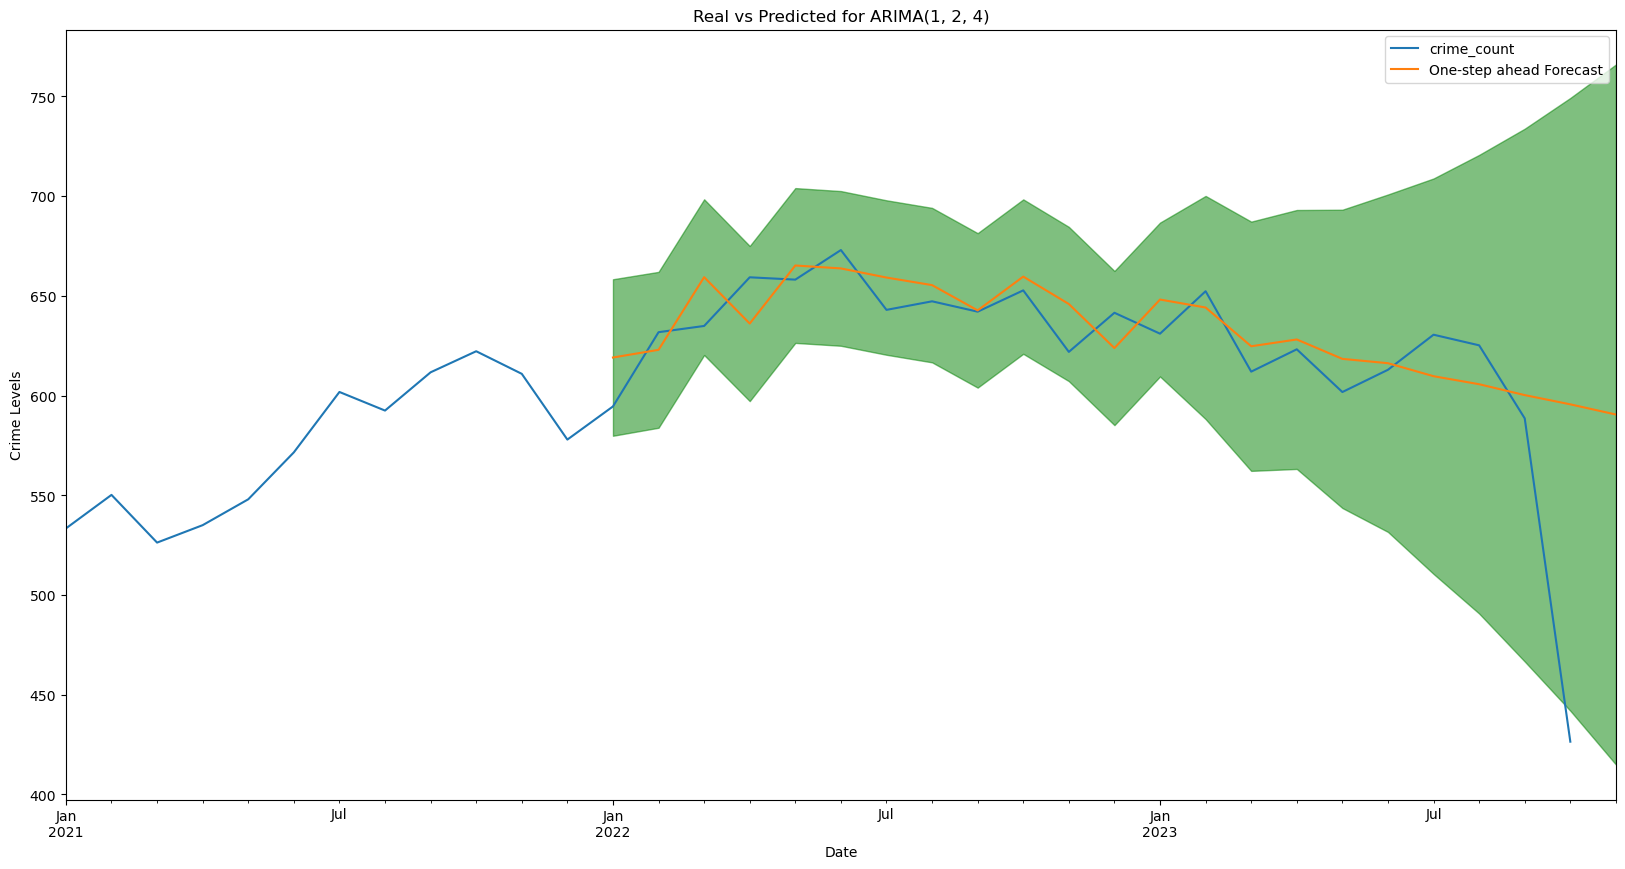

In [20]:
rcParams['figure.figsize'] = 20, 10
ax = df['2021-01-01':].plot(label='observed')
pred = model5.get_prediction(start = '2022-01-01',
                             end = '2023-10-30',
                             dynamic = False)
pred_conf = pred.conf_int()
pred.predicted_mean.plot(ax = ax, 
                         label = 'One-step ahead Forecast', 
                         alpha = 1)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], 
                color = 'g', 
                alpha = 0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Levels')
ax.set_title('Real vs Predicted for ARIMA(1, 2, 4)')
plt.legend()
plt.savefig('./fig/Real vs Predicted for ARIMA(1, 2, 4).png')
plt.show()

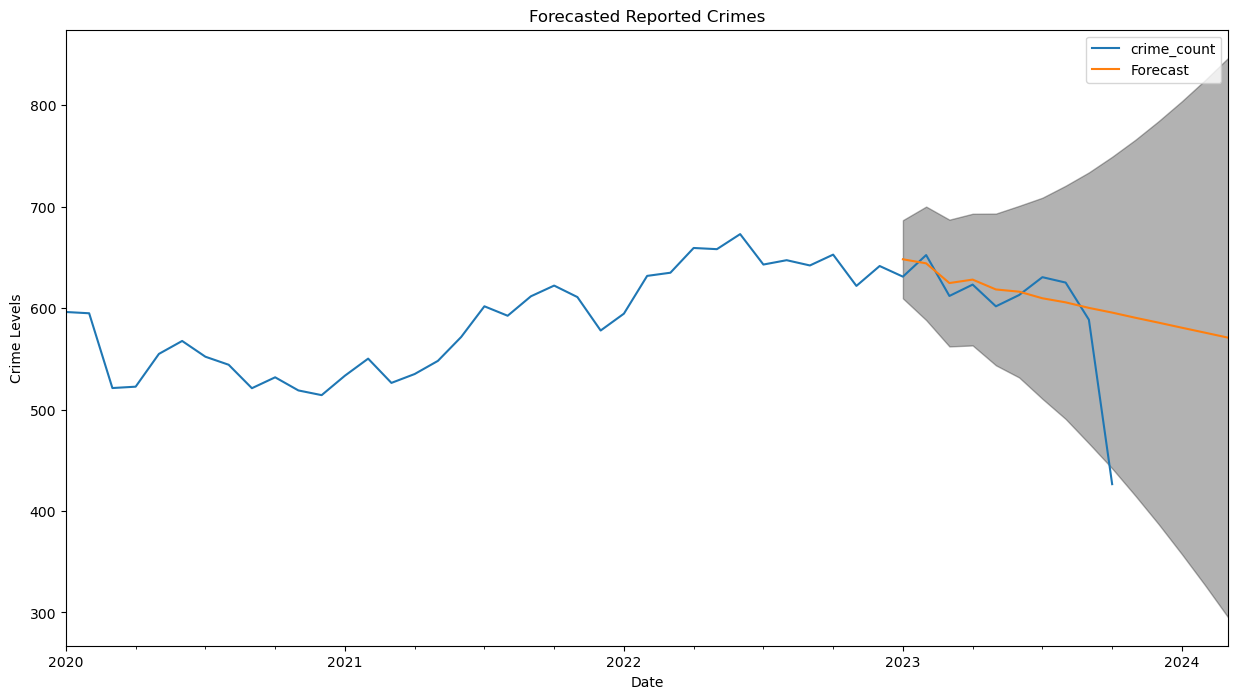

In [21]:
prediction = model5.get_forecast(steps = 15)
pred_conf = prediction.conf_int()
ax = df.plot(label = 'observed', figsize = (15, 8))
prediction.predicted_mean.plot(ax = ax, label = 'Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], 
                color = 'k', 
                alpha = 0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Levels')
ax.set_title('Forecasted Reported Crimes')
plt.legend()
plt.savefig('./fig/Forecasted Reported Crimes.png')
plt.show()